In [1]:
import os
from parsers.parser import ZipParser
from parsers.monitoring_parser import separate_and_order_columns, validate_cpu_data, validate_gpu_data, monitoring_etl
from parsers.results_parser import extract_results_data
from parsers.arielle_parser import extract_arielle_data
import pandas as pd

In [2]:
max_temp_cpu = 90.0
max_temp_gpu = 75.0
max_freq_cpu = 5486
max_freq_gpu = 2475

def process_3dmark_files(raw_directory):

    for filename in os.listdir(raw_directory):
        if filename.endswith(".3dmark-result"):
            file_path = os.path.join(raw_directory, filename)
            print(f"""Processing file: 
                  {filename}
                  """)

            parser = ZipParser(file_path)
            temp_dir = parser.extract_to_temp()

            monitoring_file = os.path.join(temp_dir, 'Monitoring.csv')
            result_file = os.path.join(temp_dir, 'Result.xml')
            arielle_file = os.path.join(temp_dir, 'Arielle.xml')
            
            if os.path.exists(monitoring_file):
                output_file = os.path.join(temp_dir, 'Monitoring_cleaned.csv')
                df_monitoring = monitoring_etl(monitoring_file, output_file, threshold=0.3)
                
                if df_monitoring is not None:
                    df_gpu, df_cpu = separate_and_order_columns(df_monitoring)

                    cpu_validation_results = validate_cpu_data(df_cpu, max_temp_cpu, max_freq_cpu)
                    print("\n CPU validation results:")
                    print(cpu_validation_results)
                    
                    gpu_validation_results = validate_gpu_data(df_gpu, max_temp_gpu, max_freq_gpu)
                    print("\n GPU validation results:")
                    print(gpu_validation_results)

                    print("\n CPU Dataframe:")
                    print(df_cpu)
                    
                    print("\n GPU Dataframe:")
                    print(df_gpu)
                    
                else:
                    print(f"\n Warning: Could not process file {filename}.")
            else:
                print(f"\n The file Monitoring.csv was not found in {filename}")
            
            if os.path.exists(result_file):
                df_results = extract_results_data(result_file) 
                
                if df_results is not None:
                    results_target = df_results[df_results.columns[df_results.columns.str.contains('ForPass')]].dropna(axis=1, how='all').dropna(how='all')
                    
                    results = df_results[df_results.columns[~df_results.columns.str.contains("ForPass")]].dropna(axis=1, how='all').dropna(how='all')
                    
                    if 'benchmarkRunId' in results_target.columns:
                        results_target = results_target.drop(columns=['benchmarkRunId'])
                    if 'passIndex' in results_target.columns:
                        results_target = results_target.drop(columns=['passIndex'])
                        
                    if 'benchmarkRunId' in results.columns:
                        results = results.drop(columns=['benchmarkRunId'])
                    if 'passIndex' in results.columns:
                        results = results.drop(columns=['passIndex'])
                        results.iloc[0] = results.iloc[0].combine_first(results.iloc[1])
                        results = results.drop(index=1).reset_index(drop=True)
                    
                    print("\n Results Dataframe:")
                    print(results)
                    
                    print("\n Results_target Dataframe:")
                    print(results_target)
                    
                else:
                    print(f"\n Warning: Could not process file {filename}.")
            else:
                print(f"\n The file Result.xml was not found in {filename}")
                
            if os.path.exists(arielle_file): 
                
                df_app_info, df_hardware_info, df_test_info, df_workload_sets = extract_arielle_data(arielle_file)
                
                if df_app_info is not None and not df_app_info.empty:
                    print("\n Application Information:")
                    print(df_app_info)
                else:
                    print(f"\n Warning: Could not extract application info from {arielle_file}.")
                
                if df_hardware_info is not None and not df_hardware_info.empty:
                    print("\nHardware Information:")
                    print(df_hardware_info)
                else:
                    print(f"\n Warning: Could not extract hardware info from {arielle_file}.")
                    
                if df_test_info is not None and not df_test_info.empty:
                    print("\nTest Info Information:")
                    print(df_test_info)
                else:
                    print(f"\n Warning: Could not extract hardware info from {arielle_file}.")
                
                if df_workload_sets is not None and not df_workload_sets.empty:
                    print("\nWorkload Set Information:")
                    print(df_workload_sets)
                else:
                    print(f"\n Warning: Could not extract hardware info from {arielle_file}.")
                    
            else:
                print(f"\n The file Arielle.xml was not found in {filename}")
                
            if zip(df_gpu, df_cpu, results_target, results, df_app_info, df_hardware_info, df_test_info, df_workload_sets) is not None:
                print(f"\n File {filename} processed successfully.")
                return df_gpu, df_cpu, results_target, results, df_app_info, df_hardware_info, df_test_info, df_workload_sets
            else:
                print(f"\n Warning: Could not process file {filename}.")
            
            parser.clean_up()


In [3]:
raw_directory = "./data/raw/"

df_gpu, df_cpu, results_target, results, df_app_info, df_hardware_info, df_test_info, df_workload_sets = process_3dmark_files(raw_directory)
#process_3dmark_files(raw_directory)

Processing file: 
                  CPU-Profile.3dmark-result
                  
Transformed file saved in C:\Users\GABOEL~1\AppData\Local\Temp\tmprs0qea7e\Monitoring_cleaned.csv

 CPU validation results:
                                        Missing values  Invalid temperature  \
BM_RunTimeSecondsE                                   0                  NaN   
CPUID_ProcessorCoreClockFrequency_0_0                0                  NaN   
CPUID_ProcessorCoreClockFrequency_0_1                0                  NaN   
CPUID_ProcessorCoreClockFrequency_0_10               0                  NaN   
CPUID_ProcessorCoreClockFrequency_0_11               0                  NaN   
CPUID_ProcessorCoreClockFrequency_0_12               0                  NaN   
CPUID_ProcessorCoreClockFrequency_0_13               0                  NaN   
CPUID_ProcessorCoreClockFrequency_0_14               0                  NaN   
CPUID_ProcessorCoreClockFrequency_0_15               0                  NaN   
CPUID

In [4]:
results

,CpuProfile4ThreadScore,CpuProfile2ThreadScore,CpuProfileSingleThreadScore,CpuProfileUnlimitedThreadsScore,CpuProfile16ThreadScore,CpuProfile8ThreadScore,CpuProfileSection0UnlimitedThreads,CpuProfileSection016Thread,CpuProfileSection08Thread,CpuProfileSection04Thread,CpuProfileSection02Thread,CpuProfileSection01Thread
0,4636,2335,1151,13795,11007,8585,25.4,31.8,40.8,75.5,149.9,303.9


In [5]:
results_target

,CpuProfile4ThreadForPass,CpuProfile8ThreadForPass,CpuProfileUnlimitedThreadsForPass,CpuProfile1ThreadForPass,CpuProfile16ThreadForPass,CpuProfile2ThreadForPass
1,4636,8585,13795,1151,11007,2335


In [6]:
df_gpu

,BM_RunTimeSecondsE,GPUZ_GpuTemperature_0_3,GPUZ_GpuLoad_0_11,GPUZ_GpuCoreClock_0_0,GPUZ_GpuMemoryClock_0_1
0,-1.183,44.61000,13.000,210.000,1312.75
1,-0.183,44.61000,13.000,210.000,1312.75
3,0.817,44.89623,1.156,2475.165,1312.75
4,1.817,44.90000,1.000,2505.000,1312.75
5,2.817,44.90000,1.000,2505.000,1312.75
...,...,...,...,...,...
193,174.817,44.20000,0.000,210.000,625.25
194,175.817,44.20000,0.000,210.000,625.25
195,176.817,44.15075,0.000,210.000,625.25
196,177.817,44.15000,0.000,210.000,625.25


In [7]:
df_cpu

,BM_RunTimeSecondsE,CPUID_ProcessorCoreTemperature_0_0,CPUID_ProcessorCoreClockFrequency_0_0,CPUID_ProcessorCoreTemperature_0_1,CPUID_ProcessorCoreClockFrequency_0_1,CPUID_ProcessorCoreTemperature_0_2,CPUID_ProcessorCoreClockFrequency_0_2,CPUID_ProcessorCoreTemperature_0_3,CPUID_ProcessorCoreClockFrequency_0_3,CPUID_ProcessorCoreTemperature_0_4,...,CPUID_ProcessorCoreTemperature_0_15,CPUID_ProcessorCoreClockFrequency_0_15,CPUID_ProcessorCoreTemperature_0_16,CPUID_ProcessorCoreClockFrequency_0_16,CPUID_ProcessorCoreTemperature_0_17,CPUID_ProcessorCoreClockFrequency_0_17,CPUID_ProcessorCoreTemperature_0_18,CPUID_ProcessorCoreClockFrequency_0_18,CPUID_ProcessorCoreTemperature_0_19,CPUID_ProcessorCoreClockFrequency_0_19
0,-1.183,88.000,4489.02000,84.000,4588.78000,86.000,4489.02000,88.000,4489.02000,88.000,...,92.000,5287.07000,73.000,3790.73000,72.000,4289.51000,73.000,3790.73000,73.000,3790.73000
1,-0.183,37.714,1144.80380,35.686,1146.20044,35.714,1144.80380,39.686,1144.80380,39.686,...,35.798,1155.97650,36.518,839.94752,36.504,846.93044,36.518,839.94752,36.518,839.94752
3,0.817,37.987,5429.51962,35.987,5429.51962,40.922,5429.51962,43.935,5429.51962,53.805,...,38.948,5429.51962,37.974,4145.65790,37.974,4145.65790,37.974,4145.65790,37.974,4145.65790
4,1.817,36.008,3698.15244,35.004,3300.72852,35.024,1909.72488,38.024,3300.72852,52.008,...,35.016,3300.72852,36.008,2898.10732,36.008,2898.10732,36.008,2898.10732,36.008,2898.10732
5,2.817,36.997,5481.19317,35.000,5479.99611,38.988,5475.80634,39.994,5479.99611,45.021,...,36.994,5479.99611,35.003,4185.85951,35.003,4185.85951,35.003,4185.85951,35.003,4185.85951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,174.817,35.007,5486.58000,34.028,5486.58000,36.986,5486.58000,46.000,5486.58000,43.000,...,37.000,5486.58000,35.000,4186.95686,35.000,4189.75000,35.000,4189.75000,35.000,4186.95686
194,175.817,36.998,5486.58000,34.000,5486.58000,36.001,5486.58000,41.005,5486.58000,41.002,...,38.998,5486.58000,35.000,4189.75000,35.000,4189.75000,35.000,4189.75000,35.000,4189.75000
195,176.817,35.030,5486.58000,35.970,5486.58000,35.015,5486.58000,41.985,5486.58000,41.000,...,39.000,5486.58000,35.000,4189.75000,35.000,4189.75000,35.000,4189.75000,35.000,4189.75000
196,177.817,34.015,5486.58000,34.030,5486.58000,35.000,5486.58000,42.000,5486.58000,41.000,...,35.060,4110.94870,35.000,4189.75000,35.000,4189.75000,35.000,4189.75000,35.000,4189.75000


In [8]:
df_app_info

,name,value
0,application_version,2.29.8294 s64
1,application_name,3DMark
2,workload_platform,x64
3,benchmark_start_time,2024-10-01T04:32:59.419243200-06:00
4,display_connected_to_gpu,true
5,benchmark_finish_time,2024-10-01T04:36:50.958658100-06:00


In [9]:
df_hardware_info

,name,value
0,display_string,Generic PnP Monitor
1,display_name,\\.\DISPLAY1
2,adapter_name,NVIDIA GeForce RTX 4070
3,write_benchmark_run_xml_path,C:\ProgramData\UL\3DMark\Results\3DMark-CPUPro...
4,present_display,\\?\DISPLAY#HKC0027#5&5997add&0&UID4353#{e6f07...
...,...,...
66,display_id,\\?\DISPLAY#HKC0027#5&5997add&0&UID4353#{e6f07...
67,draw_loading_screen,true
68,is_debug_log_enabled,false
69,scaling_mode,centered


In [10]:
df_test_info

,type,name,test_run_type,version
0,benchmark_test,CpuProfileP,EXPLICIT,1.1


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

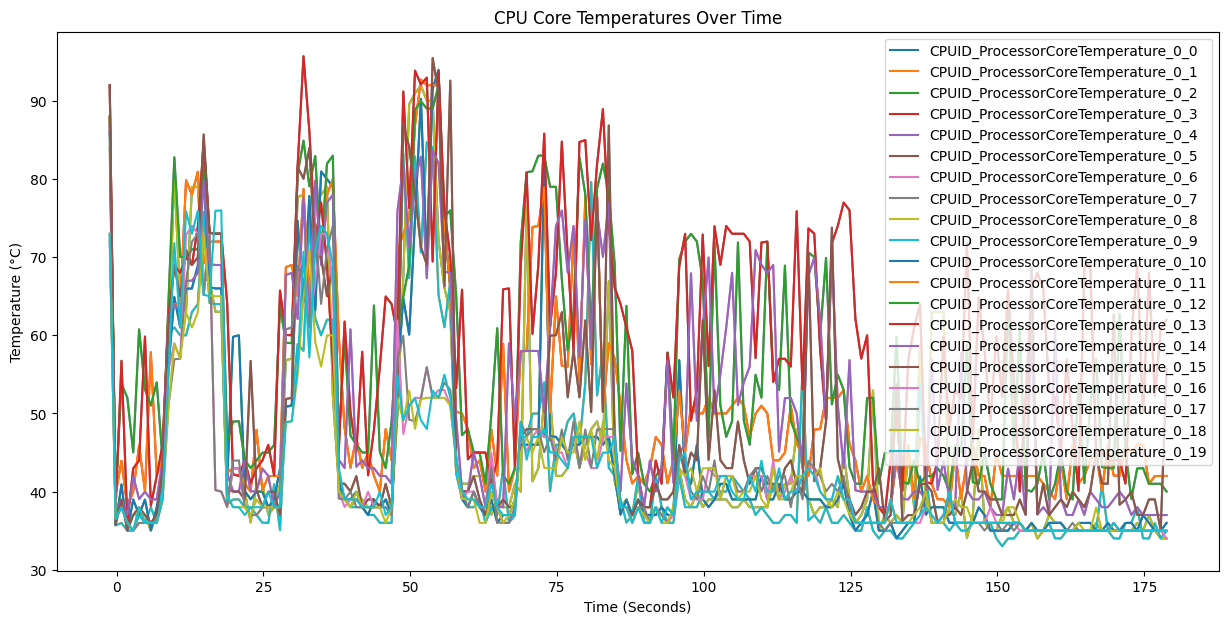

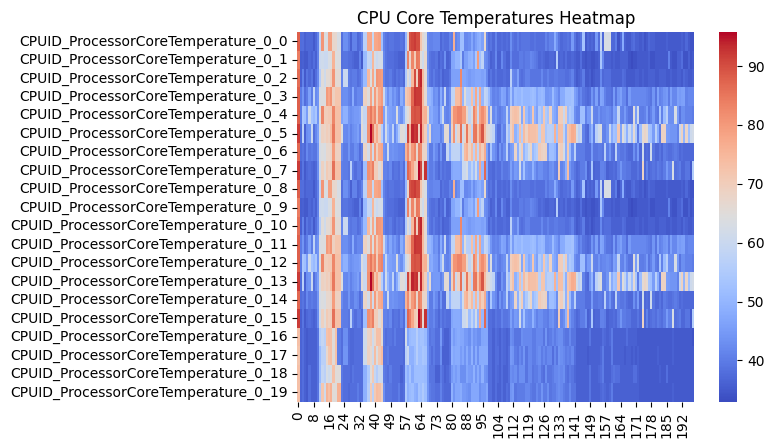

In [12]:
time = df_cpu['BM_RunTimeSecondsE']
temp_columns = [col for col in df_cpu.columns if 'Temperature' in col]

plt.figure(figsize=(15, 7))
for col in temp_columns:
    plt.plot(time, df_cpu[col], label=col)
plt.xlabel('Time (Seconds)')
plt.ylabel('Temperature (°C)')
plt.title('CPU Core Temperatures Over Time')
plt.legend()
plt.show()

temp_data = df_cpu[temp_columns].transpose()
sns.heatmap(temp_data, cmap='coolwarm')
plt.title('CPU Core Temperatures Heatmap')
plt.show()


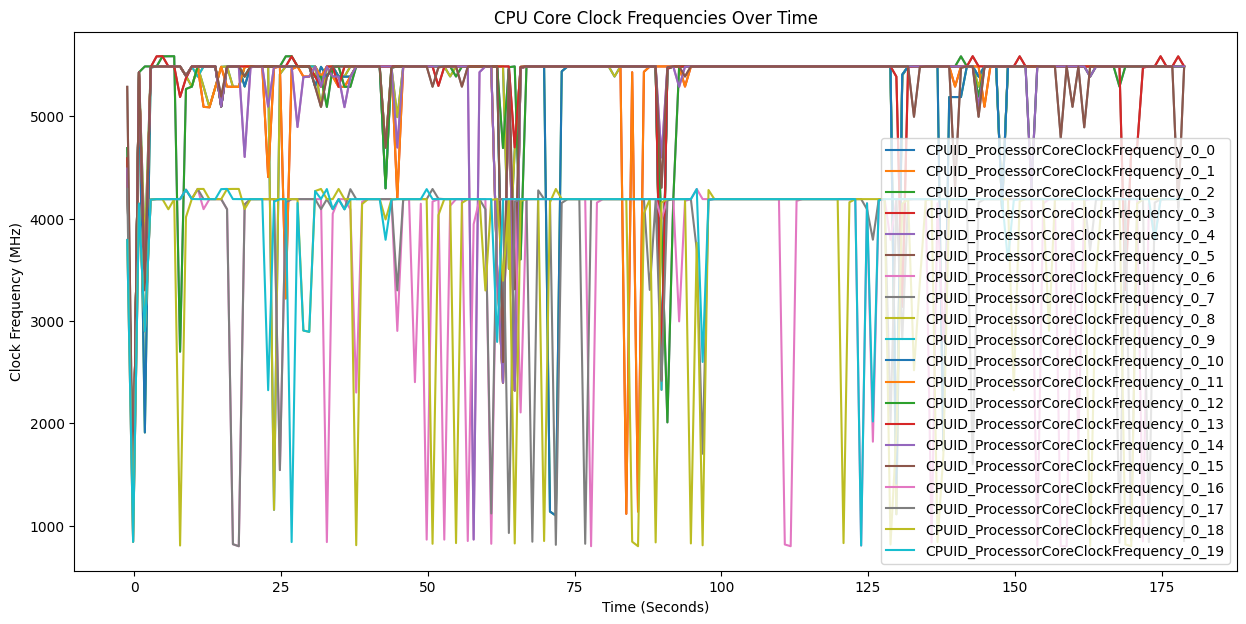

In [13]:
freq_columns = [col for col in df_cpu.columns if 'ClockFrequency' in col]

plt.figure(figsize=(15, 7))
for col in freq_columns:
    plt.plot(time, df_cpu[col], label=col)
plt.xlabel('Time (Seconds)')
plt.ylabel('Clock Frequency (MHz)')
plt.title('CPU Core Clock Frequencies Over Time')
plt.legend()
plt.show()

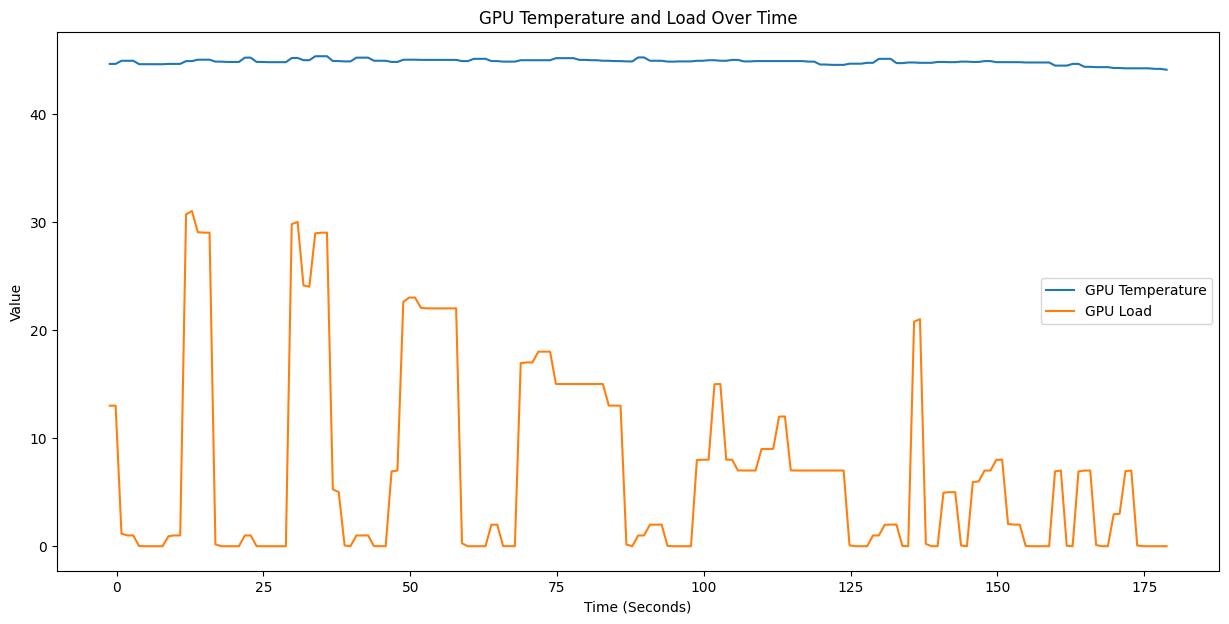

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(df_gpu['BM_RunTimeSecondsE'], df_gpu['GPUZ_GpuTemperature_0_3'], label='GPU Temperature')
plt.plot(df_gpu['BM_RunTimeSecondsE'], df_gpu['GPUZ_GpuLoad_0_11'], label='GPU Load')
plt.xlabel('Time (Seconds)')
plt.ylabel('Value')
plt.title('GPU Temperature and Load Over Time')
plt.legend()
plt.show()

In [15]:
cpu_avg_temp = df_cpu[temp_columns].mean(axis=1)
gpu_temp = df_gpu['GPUZ_GpuTemperature_0_3']

correlation = cpu_avg_temp.corr(gpu_temp)
print(f"Correlation between CPU and GPU temperatures: {correlation}")

Correlation between CPU and GPU temperatures: 0.38046665227371823


In [16]:
for col in freq_columns:
    freq_diff = df_cpu[col].diff()
    throttling_events = df_cpu.loc[freq_diff < -500]
    if not throttling_events.empty:
        print(f"Potential throttling in {col} at times:\n{throttling_events['BM_RunTimeSecondsE']}")

Potential throttling in CPUID_ProcessorCoreClockFrequency_0_0 at times:
1       -0.183
4        1.817
29      23.817
51      42.817
75      63.817
104     89.817
147    129.817
166    147.817
Name: BM_RunTimeSecondsE, dtype: float64
Potential throttling in CPUID_ProcessorCoreClockFrequency_0_1 at times:
1       -0.183
4        1.817
51      42.817
73      61.817
74      62.817
76      64.817
104     89.817
147    129.817
166    147.817
Name: BM_RunTimeSecondsE, dtype: float64
Potential throttling in CPUID_ProcessorCoreClockFrequency_0_2 at times:
1       -0.183
4        1.817
74      62.817
76      64.817
83      70.817
104     89.817
147    129.817
155    137.817
166    147.817
Name: BM_RunTimeSecondsE, dtype: float64
Potential throttling in CPUID_ProcessorCoreClockFrequency_0_3 at times:
1     -0.183
4      1.817
28    22.817
31    25.817
53    44.817
73    61.817
74    62.817
76    64.817
96    83.817
99    85.817
Name: BM_RunTimeSecondsE, dtype: float64
Potential throttling in CPUI

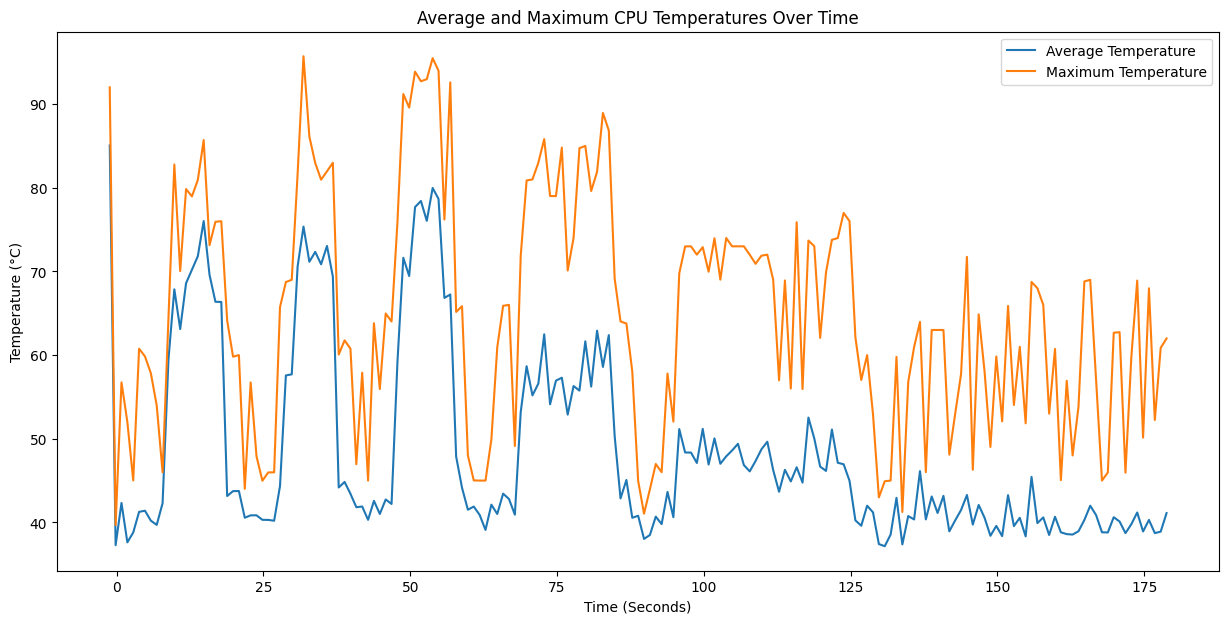

In [17]:
df_cpu['Avg_Temperature'] = df_cpu[temp_columns].mean(axis=1)
df_cpu['Max_Temperature'] = df_cpu[temp_columns].max(axis=1)

plt.figure(figsize=(15, 7))
plt.plot(time, df_cpu['Avg_Temperature'], label='Average Temperature')
plt.plot(time, df_cpu['Max_Temperature'], label='Maximum Temperature')
plt.xlabel('Time (Seconds)')
plt.ylabel('Temperature (°C)')
plt.title('Average and Maximum CPU Temperatures Over Time')
plt.legend()
plt.show()

In [18]:
temp_stats = df_cpu[temp_columns].describe()
high_temp_threshold = temp_stats.loc['75%'] + 1.5 * (temp_stats.loc['75%'] - temp_stats.loc['25%'])

outlier_cores = high_temp_threshold[high_temp_threshold > temp_stats.loc['max']]
print("Cores with unusually high temperatures:")
print(outlier_cores)

Cores with unusually high temperatures:
CPUID_ProcessorCoreTemperature_0_4     109.7350
CPUID_ProcessorCoreTemperature_0_5     106.2985
CPUID_ProcessorCoreTemperature_0_6      97.2860
CPUID_ProcessorCoreTemperature_0_12    109.7350
CPUID_ProcessorCoreTemperature_0_13    106.2985
CPUID_ProcessorCoreTemperature_0_14     97.2860
dtype: float64


In [19]:
df_gpu.to_csv('./data/gpu.csv', index=False)
df_cpu.to_csv('./data/cpu.csv', index=False)
results_target.to_csv('./data/results_target.csv', index=False)
results.to_csv('./data/results.csv', index=False)
df_app_info.to_csv('./data/app_info.csv', index=False)
df_hardware_info.to_csv('./data/hardware_info.csv', index=False)
df_test_info.to_csv('./data/test_info.csv', index=False)
df_workload_sets.to_csv('./data/workload_sets.csv', index=False)